# xAI Wake Classifier - Inference

## Required data (run to download the xAI Wakes dataset yet)
* For the .csv with the target values for training and a set of pretrained weights, go to: https://drive.google.com/drive/folders/1CUIQy77qIsx2vIdJB7D95UEzCv5_YZDL?usp=sharing
* For the dataset, run the following code:

In [ ]:
import requests
from tqdm import tqdm

def download_file(url, filename):
    """
    Download a file from the specified URL and save it locally.
    """
    # Send a GET request to the URL
    response = requests.get(url, stream=True)

    # Total size in bytes
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024  # 1 Kibibyte

    with open(filename, 'wb') as file, tqdm(
        total=total_size, unit='iB', unit_scale=True
    ) as bar:
        for data in response.iter_content(block_size):
            bar.update(len(data))
            file.write(data)

# URL of the file to be downloaded
url = "https://zenodo.org/records/10018939/files/xAIWakes.zip?download=1"

# Local filename to save the downloaded file
filename = "xAIWakes.zip"

# Download the file
download_file(url, filename)

print(f"Downloaded '{filename}'.")

* Extract the downloaded dataset:

In [ ]:
import zipfile

# Specify the path to the zip file and the extraction directory
zip_path = 'xAIWakes.zip'
extract_to = 'xAIWakes'

# Unzipping the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

* Download pretrained weights using the following code or directly from https://drive.google.com/file/d/10z9H5a82cIiTvUhf6hE6ZqvXMsOYZpp8/view?usp=sharing

In [1]:
import gdown

def download_file_from_drive(drive_link, output_file):
    gdown.download(drive_link, output_file, quiet=False)
    print("File downloaded")

# Example usage:
drive_link = "https://drive.google.com/uc?export=download&id=1NfR57Liq_1-lplvjsxMLUaB_64A8PFSD"
output_file = 'epoch=19-step=160.ckpt'

download_file_from_drive(drive_link, output_file)

Downloading...
From (uriginal): https://drive.google.com/uc?export=download&id=1NfR57Liq_1-lplvjsxMLUaB_64A8PFSD
From (redirected): https://drive.google.com/uc?export=download&id=1NfR57Liq_1-lplvjsxMLUaB_64A8PFSD&confirm=t&uuid=93e48638-596c-4006-8699-5e533a3a4220
To: C:\Users\andre\PycharmProjects\xAI_Wake_Classifier_notebook\epoch=19-step=160.ckpt
100%|██████████| 403M/403M [01:00<00:00, 6.65MB/s] 

File downloaded


## Imports

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from PIL import Image
from pathlib import Path 
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import pytorch_lightning as pl
import torchmetrics

* Function to load and transform imagery

In [3]:
def read_img(idx):
    
    def correct_dim(img):
        # If the image is not already in grayscale, convert it
        if len(img.shape) == 3 and img.shape[2] == 3:  # Assuming the image is RGB
            img_gray = img[:, :, 0]
        else:
            img_gray = img
        return img_gray

    resize_transform = transforms.Resize((256,256), antialias=True)

    b2 = [x for x in Path('xAIWakes/xAIWakes/B2').glob('**/*') if x.is_file()]
    b3 = [x for x in Path('xAIWakes/xAIWakes/B3').glob('**/*') if x.is_file()]
    b4 = [x for x in Path('xAIWakes/xAIWakes/B4').glob('**/*') if x.is_file()]
    b8 = [x for x in Path('xAIWakes/xAIWakes/B8').glob('**/*') if x.is_file()]

    # Exclude unwanted indices
    exclude_indices = [4, 80, 84, 87]  # Because B2 no_wake has some images in excess
    b2 = [b2[i] for i in range(len(b2)) if i not in exclude_indices] # Because B2 no_wake has some images in excess
    
    b2_idx = b2[idx]
    b3_idx = b3[idx]
    b4_idx = b4[idx]
    b8_idx = b8[idx]

    # Load the corresponding image of every band
    im_b2 = imageio.imread(b2_idx)
    im_b3 = imageio.imread(b3_idx)
    im_b4 = imageio.imread(b4_idx)
    im_b8 = imageio.imread(b8_idx)

    # Correct the dimensions
    im_b2 = correct_dim(im_b2)
    im_b3 = correct_dim(im_b3)
    im_b4 = correct_dim(im_b4)
    im_b8 = correct_dim(im_b8)
    
    # Convert NumPy arrays to PIL Images
    im_b2 = Image.fromarray(im_b2)
    im_b3 = Image.fromarray(im_b3)
    im_b4 = Image.fromarray(im_b4)
    im_b8 = Image.fromarray(im_b8)
    
    # Apply resizing transformation
    im_b2 = resize_transform(im_b2)
    im_b3 = resize_transform(im_b3)
    im_b4 = resize_transform(im_b4)
    im_b8 = resize_transform(im_b8)
    
    im_stack = np.stack((im_b2, im_b3, im_b4, im_b8), axis=0)
    #print("CHECK:", im_stack.shape)
    return im_stack.astype(np.float32)


## Inference Model

In [4]:
class CommonConv(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super().__init__(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=(3, 3),
                stride=(1, 1),
                padding=(1, 1),
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        )

In [5]:
class WakeClassifier(nn.Module):
    def __init__(self, in_channels=4, num_classes=2):
        super().__init__()
        self.conv_layers = nn.Sequential(
            CommonConv(in_channels=in_channels, out_channels=16),
            CommonConv(in_channels=16, out_channels=32),
            CommonConv(in_channels=32, out_channels=64),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 32 * 32, 512),  # Adjust input size based on your image dimensions
            nn.ReLU(),
            nn.Linear(512, num_classes),  # Output layer with 2 classes
            nn.Dropout(p=0.4),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [8]:
class WakeClassifierPlModule(pl.LightningModule):
    def __init__(self, in_channels=4, num_classes=2, learning_rate=1e-3):
        super(WakeClassifierPlModule, self).__init__()
        self.lr = learning_rate
        self.model = WakeClassifier(num_classes=2)

        # Other
        self.loss_fn = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.classification.BinaryAccuracy()
        self.test_accuracy = 0.0 # for hyperparameter optimization
        self.f1_score = torchmetrics.classification.BinaryF1Score()
        self.conf_matrix = torchmetrics.classification.BinaryConfusionMatrix()
        self.conf_matrix_pred = torchmetrics.classification.BinaryConfusionMatrix()

    def forward(self, x):
        # Convolutional layers with ReLU activation, batch normalization, and max pooling
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        loss, scores, y = self._common_step(batch, batch_idx)
        accuracy = self.accuracy(torch.argmax(scores, dim=1), y)
        f1_score = self.f1_score(torch.argmax(scores, dim=1), y)
        self.log_dict({
            'train_loss': loss, 
            'train_accuracy': accuracy,
            'train_f1_score': f1_score,
            },
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True
            )
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        loss, scores, y = self._common_step(batch, batch_idx)
        self.accuracy.update(torch.argmax(scores, dim=1), y)
        self.f1_score.update(torch.argmax(scores, dim=1), y)
        self.log("val_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        loss, scores, y = self._common_step(batch, batch_idx)
        accuracy = self.accuracy(torch.argmax(scores, dim=1), y)
        f1_score = self.f1_score(torch.argmax(scores, dim=1), y)
        self.conf_matrix.update(torch.argmax(scores, dim=1), y)
        self.conf_matrix.compute()
        self.log_dict({
            'test_loss': loss, 
            'test_accuracy': accuracy,
            'test_f1_score': f1_score,
            },
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True
            )
        return loss

    def on_test_end(self):
        fig_, ax_ = self.conf_matrix.plot()  # to plot and save confusion matrix
        plt.xlabel('Prediction')
        plt.ylabel('Class')
        current_datetime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        plt.savefig(rf".\tb_logs\confusion_matrix_{current_datetime}.png")
        #plt.show()

    def _common_step(self, batch, batch_idx):
        x, y = batch
        scores = self.forward(x)
        loss = self.loss_fn(scores, y)
        return loss, scores, y
    
    def predict_step(self, batch, batch_idx):
        x, y = batch
        scores = self.forward(x)
        preds = torch.argmax(scores, dim=1)
        accuracy = self.accuracy(preds, y)
        f1_score = self.f1_score(preds, y)
        self.conf_matrix_pred.update(preds, y)
        self.conf_matrix_pred.compute()

        print(f" - Accuracy: {accuracy:.3f}, F1-score: {f1_score:.3f}")
        return preds

    def on_predict_end(self):
        fig_, ax_ = self.conf_matrix_pred.plot()
        plt.xlabel('Prediction')
        plt.ylabel('Class')
        current_datetime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        plt.savefig(rf".\tb_logs\confusion_matrix_predictions_{current_datetime}.png")
        plt.show()  # test block=False

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr) # 1e-3 is a sane value for lr
        return optimizer

## Inference

Valid indexes for xAIWakes are from 1 to 269.


Input index:  163


1
tensor([[-3.6969,  1.3455]], device='cuda:0')


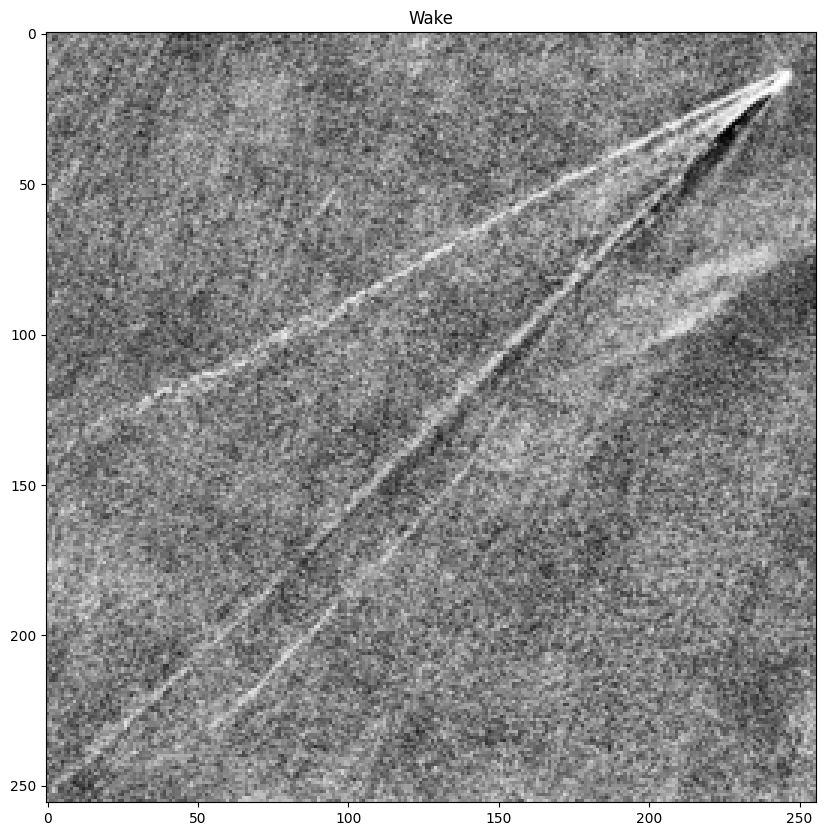

In [17]:
# Read the input image
idx = -1
while idx < 1 or idx > 269:
    try:
        print("Valid indexes for xAIWakes are from 1 to 269.")
        idx = int(input("Input index: "))
        if idx < 1 or idx > 269:
            print("Invalid index. Please enter a value between 1 and 269.")
    except ValueError:
        print("Invalid input. Please enter a valid integer.")

# Uncomment the line below, and comment the while loop, if you want to set a specific index (e.g., idx = 4)
# idx = 4

input_data = read_img(idx=idx)

# Convert to Tensor
input_tensor = torch.from_numpy(input_data)
input_tensor = input_tensor.float()
input_tensor = input_tensor.unsqueeze(0)

# Give the tensor to the right device
input_tensor = input_tensor.to('cuda' if torch.cuda.is_available() else 'cpu')

# Load the model for inference
#ckpt_path = 'epoch=19-step=120.ckpt'
ckpt_path = 'epoch=19-step=160.ckpt'
model = WakeClassifierPlModule.load_from_checkpoint(ckpt_path)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')
model = model.eval()

#model = WakeClassifier().to('cuda' if torch.cuda.is_available() else 'cpu')
#state_dict = torch.load(ckpt_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
#
## Remove "model." prefix from keys if needed
#if "model." in state_dict.keys():
#    state_dict = {key.replace("model.", ""): value for key, value in state_dict.items()}
#
## Set the model to evaluation mode
#model = model.eval()

#model_device = next(model.parameters()).device
# Sanity check to ensure the model and input tensor are on the same device
if model.device != input_tensor.device:
    raise ValueError("Model and input tensor are not on the same device!")

# Use the model for inference
with torch.no_grad():
    out = model(input_tensor)

# Get the predicted class
out_log = torch.argmax(out, dim=1)

# Print the predicted class
print(out_log.item())
print(out)

def plot_output(input_tensor, out_log):
    im = input_tensor.cpu()[0, 0, :, :]  # Move the tensor to CPU before indexing
    plt.figure(figsize=(10, 10))
    title = 'Wake' if out_log else 'Clutter'
    plt.title(title)
    plt.imshow(im.numpy(), cmap='gray')
    plt.show()
    
plot_output(input_tensor=input_tensor, out_log=out_log.item())